# Lab 3: Modeling Stellar Spectra
## Technical Components
* Data Munging and Standardization
* Outlier Rejection; removing bad data
* Linear Models
* Cross Validation
* Nonlinear Optimization; MCMC
* Basics of Stellar Evolution
* Making Movies
* Neural Networks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns; sns.set()
import gc
import read_mist_models
import urllib.request
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.table import Table, vstack
import os
import shutil
import corner
from sklearn.model_selection import train_test_split

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

In [59]:
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import tensorflow as tf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Print keras version
print(tensorflow.keras.__version__)

from tensorflow import keras
print(f"backend={keras.backend.backend()}")

2.2.4-tf
backend=tensorflow


# Problem 1

Download a subset of the APOGEE spectra in the form of apStar files. Make sure you are always accessing the most recent version of the spectra (DR16). For this lab, we’ll download all the spectra with
the following 4 (randomly chosen) fields: “M15”, “N6791”, “K2_C4_168-21”, and “060+00”. This will give us 3036 spectra. Each apStar file contains individual visit and coadded multi-visit
spectra for one star. Explain what this means, and what the point of multi-vist spectra is. Helpfully, the coadded spectra have already been Doppler shifted to the barycentric frame. Explain
what this means, and why the Doppler shift will be different for each visit. The apStar files also
contain the associated error arrays and a quality flag bitmask, plus some other information. The data
model is described in detail on the SDSS website. Figure out how to read in each spectrum and reconstruct the wavelength array. Plot an example spectrum (flux vs. wavelength). What are the units of
spectra? Explain what these units mean.

In [18]:
## downloading a subset of the APOGEE spectra in the form of apStar files ##

"""
## don't run this cell since all files already downloaded ##

fields = ['M15', 'N6791', 'K2_C4_168-21', '060+00']
loaded_spectra = []
for field in fields:
    # reading the file names
    files = pd.read_csv(
        f'https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/{field}/r12_stars_apo25m_{field}.sha1sum',
        delimiter = ' ', names = ['NaN', 'file'])
    all_files = files['file'].values.tolist()
    
    # filtering out for only the files that have r12 in the name
    r12_files = []
    for file in all_files:
        if 'r12' in file:
            r12_files.append(file)
            loaded_spectra.append(file)
    
    # loading the files
    for file in r12_files:
        url = f'https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/{field}/{file}'
        urllib.request.urlretrieve(url, file)

print(len(loaded_spectra))
"""        

3036


Multi-visit spectra are spectra that are integrated over many visits that are separated by at least one month. This enables the identification of binary stars through radial velocity variations. Doppler shifted to the barycentric frame means that the spectra are redshifted because they are moving away from us, so we must account for that in order to get the actual wavelength rather than the shifted one. 

The apStar files also
contain the associated error arrays and a quality flag bitmask, plus some other information. The data
model is described in detail on the SDSS website. Figure out how to read in each spectrum and reconstruct the wavelength array. Plot an example spectrum (flux vs. wavelength). What are the units of
spectra? Explain what these units mean.

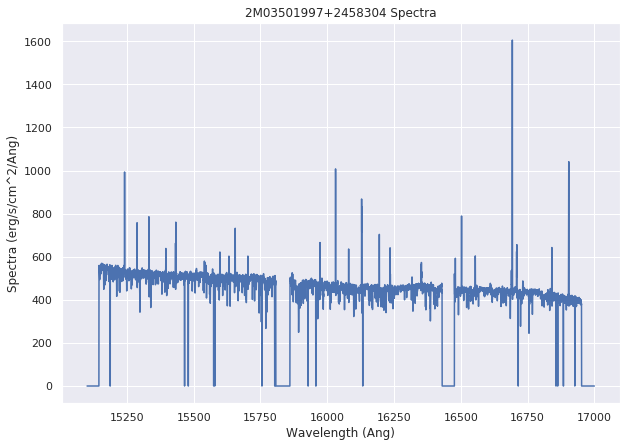

In [2]:
## plotting an example spectrum (flux vs. wavelength) ##

example = 'apStar-r12-2M03501997+2458304.fits'
example_file = get_pkg_data_filename(example)
example_data = fits.getdata(example_file, ext=1)

with fits.open(example_file) as hdul:
    start = hdul[0].header['CRVAL1']
    step = hdul[0].header['CDELT1']
    num = hdul[0].header['NWAVE']

end = start + step*num
wavelength = 10**np.array(np.arange(start,end,step))

plt.figure(figsize=(10,7))
plt.plot(wavelength, example_data[0])
plt.title("2M03501997+2458304 Spectra")
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Spectra (erg/s/cm^2/Ang)')
plt.show()

The units of spectra are erg/s/cm^2/Ang which is equivalent to flux over wavelength.

# Problem 2

To build a training set, we also need to know the stellar properties (“labels”) that have been derived
for each spectrum by the ASPCAP pipeline (Garcia-Perez et al. 2015). These can be found in the
“allStar” catalog, which you should download. For each spectrum you downloaded, find its labels in
the allStar catalog.
Due to data quality issues, not all labels have been derived for all stars. Discard all spectra for
which any of the following labels have not been derived: Teff, logg, [Fe/H], [Mg/Fe], [Si/Fe]. Also
discard spectra with low signal-to-noise ratio (SNR < 50, as reported in the allStar catalog). Finally,
discard the spectra of dwarfs (log g > 4 or Teff > 5, 700 K); we’ll be focusing on giants in this lab) and
stars with low metallicity ([Fe/H] < −1).
Explain how our cut on log g effectively distinguishes between dwarfs and giants. Suppose you have
a solar-mass star. Calculate the expected value of log g on the main sequence (when R ∼ 1R), just
before the helium flash (when R ∼ 100R), and during core helium burning (when R ∼ 15R).
You should be left with 1855 stars. Visualize their distribution in label space using a corner plot.

In [3]:
## downloading 'allStar' catalog for stellar properties/labels ##

labels = Table.read('allStarLite-r12-l33.fits', hdu=1)  
labels.info()
gc.collect() 

<Table length=473307>
           name             dtype   shape n_bad
-------------------------- -------- ----- -----
                 APOGEE_ID  bytes18           0
                 TELESCOPE   bytes8           0
                     FIELD  bytes16           0
                         J  float32           0
                     J_ERR  float32           0
                         H  float32           0
                     H_ERR  float32           0
                         K  float32           0
                     K_ERR  float32           0
                        RA  float64           0
                       DEC  float64           0
                      GLON  float64           0
                      GLAT  float64           0
            APOGEE_TARGET1    int32           0
            APOGEE_TARGET2    int32           0
            APOGEE_TARGET3    int32           0
           APOGEE2_TARGET1    int32           0
           APOGEE2_TARGET2    int32           0
           APOGEE2

2638

In [4]:
## getting only fields “M15”, “N6791”, “K2_C4_168-21”, and “060+00” ##

label_select = labels.group_by('FIELD')
del labels
m15 = label_select.groups.keys['FIELD'] == 'M15'
n6791 = label_select.groups.keys['FIELD'] == 'N6791'
k2_c4 = label_select.groups.keys['FIELD'] == 'K2_C4_168-21'
s060 = label_select.groups.keys['FIELD'] == '060+00'
gc.collect()

0

In [5]:
## filtering for fields ##
filtered_labels = vstack([label_select.groups[m15], 
                          label_select.groups[n6791], 
                          label_select.groups[k2_c4], 
                          label_select.groups[s060]])
gc.collect()
del label_select, m15, n6791, k2_c4, s060

In [6]:
## making filters ##

# using M_H instead of FE_H
def filters(row):
    
    # discard all spectra that Teff, logg, [Fe/H], [Mg/Fe], [Si/Fe] have not been derived
    if row['TEFF'] <= -9999 or row['LOGG'] <= -9999 or row['M_H'] <= -9999 or row['MG_FE'] <= -9999 or row['SI_FE'] <= -9999:
        return True
    
    # discard the spectra of dwarfs (log g > 4 or Teff > 5,700 K)
    elif row['LOGG'] > 4 or row['TEFF'] > 5700:
        return True
    
    # discard stars with low metallicity ([Fe/H] < −1)
    elif row['M_H'] < -1:
        return True
    
    # discard spectra with low signal-to-noise ratio (SNR < 50)
    elif row['SNR'] < 50:
        return True
    
    else:
        return False

In [7]:
## removing files ##

for i in range(0,5):
    for j,row in enumerate(filtered_labels):
        if filters(row):
            filtered_labels.remove_row(j)

for filename in os.listdir():
    if filename.endswith(".fits") & filename.startswith("apStar-r12"): 
        with fits.open(filename) as hdul:
            if hdul[0].header['OBJID'] not in filtered_labels['APOGEE_ID']:
                os.remove(filename)     

The cut on logg distinguishes between dwarfs and giants because a giant will have less surface gravity whereas a dwarf will have higher surface gravity.

In [8]:
teff = filtered_labels['TEFF'].reshape(-1,1)
logg = np.reshape(filtered_labels['LOGG'], (-1,1))
m_h = np.reshape(filtered_labels['M_H'], (-1,1))
mg_fe = np.reshape(filtered_labels['MG_FE'], (-1,1))
si_fe = np.reshape(filtered_labels['SI_FE'], (-1,1))

1855 stars after filters/discarding


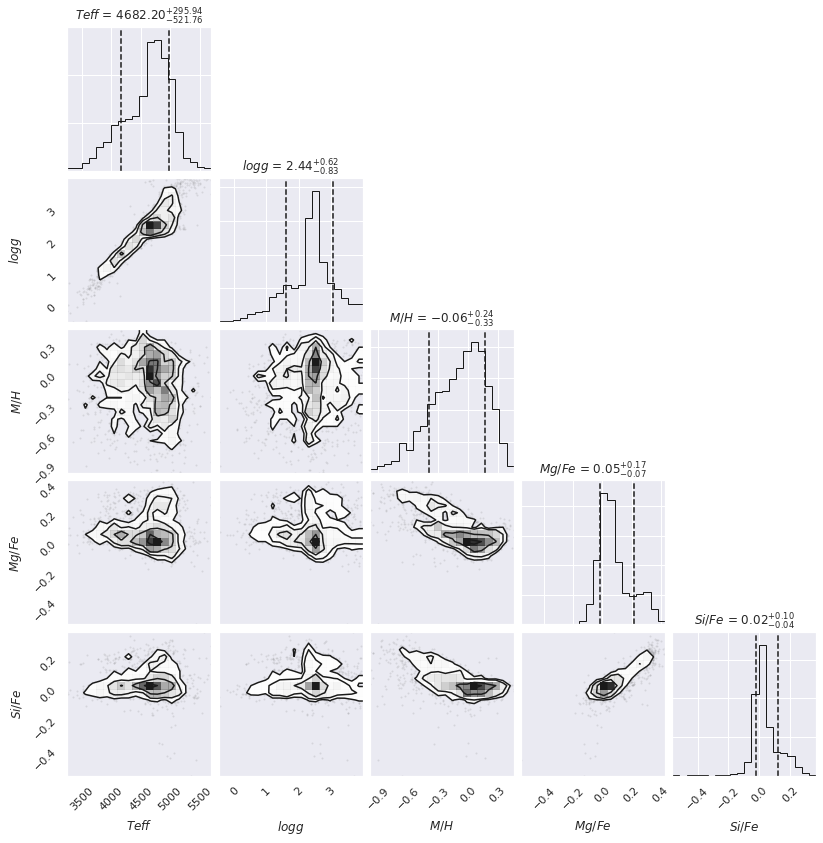

In [9]:
## make corner plot ##

print('{} stars after filters/discarding'.format(len(filtered_labels['TEFF'])))
samples = np.hstack([teff, logg, m_h, mg_fe, si_fe])
figure = corner.corner(samples, 
                       labels=["$Teff$", "$logg$", "$M/H$", "$Mg/Fe$", "$Si/Fe$"], 
                       show_titles=True, 
                       quantiles=[0.16, 0.84])

# Problem 3

Use the apStar bitmasks to identify bad pixels in each spectrum (i.e. pixels where sky subtraction
failed, there was a cosmic ray strike, or something else bad happened). Set the uncertainty in these
pixels to a large value, so that they will not contribute significantly to the likelihood function in your
fitting. The bitmask are a bit unintuitive but are described on in APOGEE data model. To see what
each bit means for APOGEE spectra, check the “APOGEE_PIXMASK: APOGEE pixel level mask
bits” dropdown menu. Based on our experience, bits 0-7 and 12 are the most important; the others
can probably be ignored.

In [10]:
## Set the uncertainty in the bad pixelspixels to a large value ##

for filename in os.listdir():
    if filename.endswith(".fits") & filename.startswith("apStar-r12"): 
        with fits.open(filename) as hdul:
            try:
                mask = hdul[3].data[0]
                error = hdul[2].data[0]
                spec = hdul[1].data[0]

                bits = (2**0)+(2**1)+(2**2)+(2**3)+(2**4)+(2**5)+(2**6)+(2**7)+(2**12)
                bad_pixels = (mask & bits) != 0
                np.putmask(error, bad_pixels, 1e10) 
            
            except TypeError:
                continue


# Problem 4

Before we fit spectra, we need to “pseudo-continuum normalize” them, as described in Ness et al. 2015.
Explain what this means and why it is useful. What is the difference between pseudo-continuum normalization and “true” continuum normalization?

Continuum normalization is done in order to remove the continuum pixels from the spectrum. This is done in order to remove dependency of SNR to identify continuum pixels. However in order to reach 'true' continuum normalization, we need to use the model derived from the pseudo-continuum-normalized spectra, which is SNR dependent but finds continuum pixels while only having a small systemtic dependence of the spectra on SNR.

Developing a continuum normalization procedure from scratch is challenging: an iterative method
is required to determine which wavelengths are insensitive to label changes (and thus good for fitting
continuum). To find out more about this, read sections 2.3 and 5.3 of Ness et al. 2015.
In this lab, we are making the problem a bit easier by proving you with a list of wavelengths (“continuum_pixels_apogee.npz”) that do not contain any strong absorption lines. In other words, the flux
value at these wavelengths should not depend much on the spectral labels of the star, but only on its
absolute magnitude and distance. Write a function that uses the flux in these wavelength pixels to
estimate the continuum over the full APOGEE wavelength range. Section 2.3 of Ness et al. 2015 should
be useful. Because the APOGEE spectra are split over three chips, with gaps between the chips, your
continuum-determination procedure will probably work better if you handle the three chips individually. Normalize all your spectra and error arrays. Plot some example un-normalized spectrum, the derived
pseudo-continuum, and the normalized spectrum. In order for the rest of your lab to be successful, it
is critical that the normalization is robust and behaves as expected in all cases. We recommend testing
it thoroughly before moving on to the next part of the lab. If your routine is robust, you should find
that the normalized spectra of stars that have similar labels (according to ASPCAP) are very similar.
Any artifacts (e.g. wiggles) introduced by your normalization procedure will reduce the performance
of your spectral model.

In [11]:
## reading “continuum_pixels_apogee.npz” and its contents ##

wavelength_file = np.load('continuum_pixels_apogee.npz', 'r+')
lst = wavelength_file.files

for item in lst:
    print(item)
    print(wavelength_file[item])

wavelength
[15168.128527   15168.33808389 15168.54764367 ... 16936.27902239
 16936.51300735 16936.74699554]
is_continuum
[False False False ... False False False]


In [39]:
## create function that normalizes spectra ##

def pseudo_continuum(wavelength_file, apogee_file, plots = False):

    # getting wavelengths that correspond with 'is_continuum'==True
    continuum = wavelength_file['wavelength'][wavelength_file['is_continuum']==True]

    # rounding wavenlengths to 2 decimal points and split into sections
    full_continuum = []
    continuum1 = []
    continuum2 = []
    continuum3 = []
    for wavelength in continuum:
        wavelength = round(wavelength, 2)
        full_continuum.append(wavelength)
        # (i) 15150 - 15800 ˚A
        if 15150 < wavelength < 15800:
            continuum1.append(wavelength)
        # (ii) 15890 - 16430 ˚A    
        elif 15890 < wavelength < 16430:
            continuum2.append(wavelength)
        # (iii) 16490 - 16950 ˚A
        elif 16490 < wavelength < 16950:
            continuum3.append(wavelength)
    

    read_file = get_pkg_data_filename(apogee_file)
    data = fits.getdata(read_file, ext=1)


    with fits.open(read_file) as hdul:

        spec = hdul[1].data[0]
        error = hdul[2].data[0]
        start = hdul[0].header['CRVAL1']
        step = hdul[0].header['CDELT1']
        num = hdul[0].header['NWAVE']

        end = start + step*num
        wvl = np.array(np.arange(start,end,step)) # log(wavelength)
        wvl = 10**wvl

        # round wavelengths to 2 decimal points and breaking up into sections
        full_wavelength = []
        wavelength1 = []
        wavelength2 = []
        wavelength3 = []
        for w in wvl:
            w = round(w, 2)
            full_wavelength.append(w)
            # (i) 15150 - 15800 ˚A
            if 15150 < w < 15800:
                wavelength1.append(w)
            # (ii) 15890 - 16430 ˚A    
            elif 15890 < w < 16430:
                wavelength2.append(w)
            # (iii) 16490 - 16950 ˚A
            elif 16490 < w < 16950:
                wavelength3.append(w)


        # create dataframe of wavelength and spectra
        full_df = pd.DataFrame({'wavelength': np.array(full_wavelength).byteswap().newbyteorder(),
                              'spectra': spec.byteswap().newbyteorder(),
                              'error': error.byteswap().newbyteorder()}).set_index('wavelength')

        # getting the spectra from wavelengths that correspond to npz file and are in continuum
        df_1 = full_df[full_df.index.isin(continuum1)]
        df_2 = full_df[full_df.index.isin(continuum2)]
        df_3 = full_df[full_df.index.isin(continuum3)]

        # fitting least squares fit of Chebyshev series to data in sections
        cheb1 = np.polynomial.chebyshev.chebfit(continuum1, df_1['spectra'], 5)
        cheb2 = np.polynomial.chebyshev.chebfit(continuum2, df_2['spectra'], 5)
        cheb3 = np.polynomial.chebyshev.chebfit(continuum3, df_3['spectra'], 5)

        # evaluating the entire spectrum using coefficients found in fitting
        val1 = np.polynomial.chebyshev.chebval(wavelength1, cheb1)
        val2 = np.polynomial.chebyshev.chebval(wavelength2, cheb2)
        val3 = np.polynomial.chebyshev.chebval(wavelength3, cheb3)

        # putting into dataframe
        pseudo_df = pd.DataFrame({'wavelength': [*wavelength1,*wavelength2,*wavelength3],
                                  'spectra': [*val1,*val2,*val3]})
        new_df = full_df.join(pseudo_df.set_index('wavelength'),lsuffix = 'A').drop('spectraA', axis = 1)


        # normalizing spectra and error arrays

        normalized_spectra = spec/new_df['spectra']
        normalized_spectra = np.array(normalized_spectra)
        normalized_error = new_df['error'][new_df['spectra'].notna()]/np.std(new_df['spectra'])
        normalized_spectra = [x for x in normalized_spectra if (str(x)!='nan' and str(x)!='inf')]
        normalized_error = [x for x in normalized_error if (str(x)!='nan' and str(x)!='inf')]
        wavelength = new_df.index[new_df['spectra'].notna()]
        
        if plots == True:
            star_name = apogee_file.split('-')[2]
            star_name = star_name.split('.')[0]
            # graphing un-normalized spectrum, derived pseudo-continuum
            plt.figure(figsize=(10,7))
            plt.plot(full_df.index, full_df['spectra'], label = 'Full, un-normalized Spectrum')
            plt.plot([*wavelength1,*wavelength2,*wavelength3], 
                     [*val1,*val2,*val3], c = 'r', linewidth=2.0, label = 'Pseudo-Continuum')
            plt.title(f'Un-normalized Spectrum and Derived Pseudo-Continuum for {star_name}')
            plt.xlabel('Wavelength (Ang)')
            plt.ylabel('Spectra (erg/s/cm^2/Ang)')
            plt.legend()
            plt.show()

            # graphng normalized spectrum
            plt.figure(figsize=(10,7))
            plt.plot(wavelength, normalized_spectra, label = 'Full, normalized Spectrum')
            plt.title(f'Normalized Spectrum for {star_name}')
            plt.xlabel('Wavelength (Ang)')
            plt.ylabel('Spectra (erg/s/cm^2/Ang)')
            plt.legend()
            plt.show()
            
        else:
            pass
        
        return [*val1,*val2,*val3], normalized_spectra, normalized_error, wavelength
        del continuum, full_continuum, continuum1, continuum2, continuum3, star_name, read_file, data, \
            spec, error, start, step, num, end, wvl, full_wavelength, wavelength1, wavelength2, wavelength3, \
            full_df, df_1, df_2, df_3, cheb1, cheb2, cheb3, pseudo_df, new_df


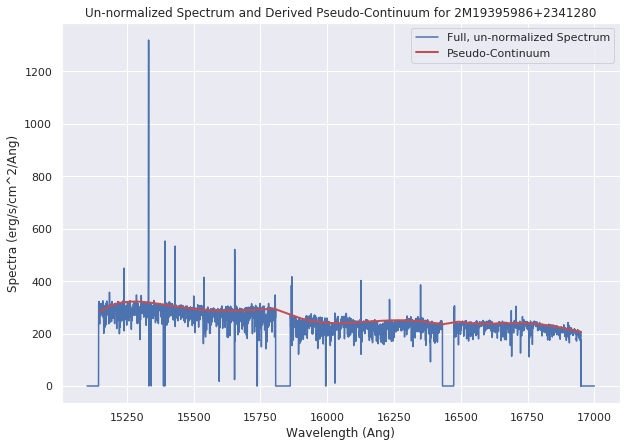

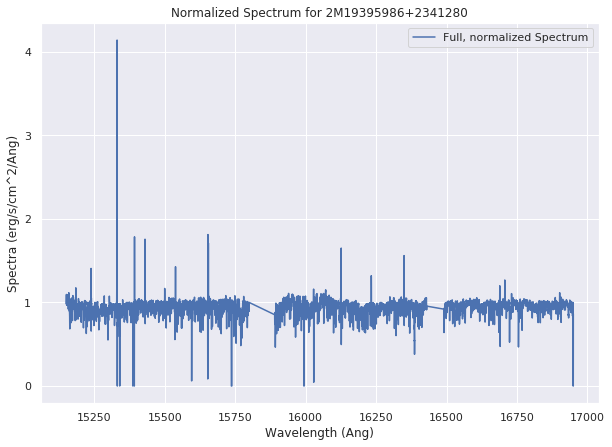

In [40]:
## showing plots for only one star ##

apogee_file = 'apStar-r12-2M19395986+2341280.fits'

pseudo_values, normalized_spectra, normalized_error, wavelength = pseudo_continuum(wavelength_file, apogee_file, plots=True)

# del apogee_file, pseudo_values, normalized_spectra, normalized_error

In [14]:
## cleaning spectra files ##

final = filtered_labels.group_by('APOGEE_ID')
id_list = []
spec_list = []
error_list = []
variable_list = []


for entry in final:
    try:
        filename = 'apStar-r12-'+ entry['APOGEE_ID'] +'.fits'
        pseudo_values, normalized_spectra, normalized_error, wavelength = pseudo_continuum(wavelength_file, 
                                                                                   filename, 
                                                                                   plots=False)
        normalized_spectra = [x for x in normalized_spectra if (str(x)!='nan' and str(x)!='inf')]
        normalized_error = [x for x in normalized_error if (str(x)!='nan' and str(x)!='inf')]
        spec_list.append(normalized_spectra)
        error_list.append(normalized_spectra)
        id_list.append(entry['APOGEE_ID'])

        with fits.open(filename) as hdul:       
            variable_list.append([entry['TEFF'], entry['LOGG'], entry['FE_H'], entry['MG_FE'], entry['SI_FE']])
    
    except TypeError:
        continue

data = pd.DataFrame({'Apogee_ID': id_list,
                     'Spectra': spec_list,
                     'Error': error_list,
                     'Labels': variable_list}).set_index('Apogee_ID')

# getting rid of the rows that have empty lists
data = data[data['Spectra'].map(lambda d: len(d)) > 0]

print(f'All {len(spec_list)} stars loaded')  
gc.collect()

All 1855 stars loaded


451

In [15]:
del id_list, spec_list, error_list, variable_list

# Problem 5
 Now that you have cleaned spectra, divide them into two randomly selected groups of roughly equal
size. Designate one group the training set and the other the cross-validation set.

In [168]:
"""
## rescaling labels to order of unity ##
teff = [item[0] for item in data['Labels']]
logg = [item[1] for item in data['Labels']]
m = [item[2] for item in data['Labels']]
mg = [item[3] for item in data['Labels']]
si = [item[4] for item in data['Labels']]
norm_teff = [(item - np.mean(teff))/np.std(teff) for item in teff]
norm_logg = [(item - np.mean(logg))/np.std(logg) for item in logg]
norm_m = [(item - np.mean(m))/np.std(m) for item in m]
norm_mg = [(item - np.mean(mg))/np.std(teff) for item in mg]
norm_si = [(item - np.mean(si))/np.std(si) for item in si]
norm_labels = np.vstack([norm_teff,norm_logg,norm_m,norm_mg,norm_si]).T
data['Norm Labels'] = norm_labels.tolist()
"""

In [16]:
## designated train and test groups ##

X_train, X_test, y_train, y_test = train_test_split(
     data[['Labels', 'Error']], data['Spectra'], test_size=0.5, random_state=42)

# Problem 6 
Use the training set to build a spectral model that predicts the spectrum at each wavelength pixel as a
function of the following 5 labels: Teff, logg, [Fe/H], [Mg/Fe], [Si/Fe]. Following Ness et al., make your
spectral model a 2nd-order polynomial in labels. Your final spectral model will consist of thousands
of individual models — one for each wavelength pixel — stitched together. In addition to the model
free parameters, fit an intrinsic scatter term, s
2
λ
, at each wavelength. This term is defined such that
the variance in the observed normalized flux values at wavelength λ is given by s
2
λ + σ
2
λ
, where σλ
represents the uncertainty in the normalized flux.

### (a)
Consider a single pixel of wavelength λ. Let fλ be an array containing the normalized flux in that
pixel for all stars in the training set. Show that at a fixed value of s
2
λ
, the spectral model for the
pixel can be described by a linear equation Xθλ = fλ, where θλ is an array of model parameters
for that pixel and X is a matrix that is the same for all pixels. What is X? For a spectral model
that is a 2nd order polynomial in labels, how many free parameters are in θλ (where n = 5 in
your case)? Equation 8 of Ness et al. 2015 may provide some useful context here.

In [17]:
## creating X matrix ##

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X = poly.fit_transform(X_train['Labels'].tolist())
print(X.shape)


(926, 21)


In [18]:
print(f'X is a matrix of 2nd order polynomial in labels for each star \
and there are {X.shape[1]} free parameters')

X is a matrix of 2nd order polynomial in labels for each star and there are 21 free parameters


### (b) 
To find the best values of s
2
λ
and θλ for all pixels, consider a grid of s
2
λ
values for each pixel.
Stepping though the grid, solve the linear equation for θλ and compute the likelihood for the
training set for that value of s
2
λ
. There should be a term in this likelihood that explicitly depends
on sλ. Choose the optimal θλ and s
2
λ
as the one that maximizes that likelihood. Ensure your grid
of s
2
λ
is large and fine enough that you are actually finding a global maximum in the likelihood.

In [19]:
## finding theta for one pixel ##

from numpy.linalg import inv, solve
import time

start_time = time.time()

f_pixel = [item[0] for item in y_train]
error_pixel = [item[0] for item in X_train['Error']]
inv_error_sq = np.array([1/(error**2) for error in error_pixel])

new_inv_error_sq = []
for error in inv_error_sq:
    if np.isinf(error):
        new_inv_error_sq.append(0.0)
    else:
        new_inv_error_sq.append(error)

inv_C = np.diag(new_inv_error_sq)
X_transp = X.T
matrix1 = X_transp.dot(inv_C).dot(X)
matrix2 = X_transp.dot(inv_C).dot(f_pixel)
theta = solve(matrix1, matrix2).reshape(-1,1) # (21,1)
print(f'Theta values for one pixel for each star in training set: \n{theta}')
print(f'Time to find theta for one pixel {time.time() - start_time} seconds')
gc.collect()

Theta values for one pixel for each star in training set: 
[[-2.75466052e+00]
 [ 1.46228533e-03]
 [-1.55186994e-05]
 [ 2.91865523e-01]
 [-5.05172966e-01]
 [ 1.16751019e+00]
 [-1.44211343e-07]
 [ 2.25448974e-06]
 [-6.28024108e-05]
 [ 1.51030817e-04]
 [-2.46845971e-04]
 [ 8.17437753e-04]
 [-6.13639158e-03]
 [-9.20697618e-02]
 [ 6.14810245e-02]
 [-1.75764942e-02]
 [ 2.23256716e-02]
 [ 1.69975854e-01]
 [ 8.92234025e-02]
 [-9.85681244e-01]
 [ 1.25071606e+00]]
Time to find theta for one pixel 0.018939495086669922 seconds


0

In [20]:
## using single pixel likelihood to get best s values for one pixel ##

start_time = time.time()

s_list = np.linspace(0,0.1,50)
max_likelihood = None
best_s = 0  
for s in s_list:
    a = (f_pixel-(theta.T.dot(X_transp)))**2
    b = [(error**2 + s**2) for error in error_pixel]
    likelihood_func = np.sum((-0.5)*(a/b) + np.log(b))
    if max_likelihood == None:
        max_likelihood = likelihood_func
    elif likelihood_func > max_likelihood:
        max_likelihood = max(max_likelihood,likelihood_func)
        best_s = s
    else:
        continue
print(max_likelihood)
print(f'Best s value for one pixel is {best_s}')
print(f'Time to find s for one pixel {time.time() - start_time} seconds')
gc.collect()

-1838.3743432612928
Best s value for one pixel is 0.1
Time to find s for one pixel 0.16120076179504395 seconds


0

### (c) 
Repeat for all wavelength pixels. What is the total number of free parameters in your spectral
model?

In [21]:
""" already ran the cell and saved values to file 
## repeating part (b) for all wavelength pixels ##

print('Loading for all wavelength pixels')
start_time = time.time()
# how many pixels are there?
len_pixels = len(y_train[0]) # 7451 pixels

all_theta = [] # (7451,21)
all_s = [] # (7451,1)

for pixel in range(len_pixels):

    f_pixel = [item[pixel] for item in y_train]
    error_pixel = [item[pixel] for item in X_train['Error']]
    inv_error_sq = [1/(error**2) for error in error_pixel]
    inv_C = np.diag(inv_error_sq)
    X_transp = X.T
    matrix1 = X_transp.dot(inv_C).dot(X)
    matrix2 = X_transp.dot(inv_C).dot(f_pixel)
    theta = solve(matrix1, matrix2)
    all_theta.append(theta)
    
    s_list = np.linspace(0,0.1,100)
    max_likelihood = None
    best_s = 0  
    for s in s_list:
        a = (f_pixel-(theta.dot(X_transp)))**2
        b = [error**2+s**2 for error in error_pixel]
        likelihood_func = np.sum((-0.5)*(a/b) + np.log(b))
        if max_likelihood == None:
            max_likelihood = likelihood_func
        elif likelihood_func > max_likelihood:
            max_likelihood = max(max_likelihood,likelihood_func)
            best_s = s
        else:
            continue
    all_s.append(best_s)

print(f'Time to load all pixels for all stars {time.time() - start_time}')
"""

Loading for all wavelength pixels
Time to load all pixels for all stars 2528.7534737586975


In [22]:
"""
## saving values to file so I don't have to run above cell again ##
np.savetxt('theta_matrix2.txt', all_theta, delimiter = ',')  
np.savetxt('s_list2.txt', all_s, delimiter = ',')
"""

In [21]:
theta_matrix = np.loadtxt(open("theta_matrix2.txt","rb"),delimiter=",",skiprows=0)
s_values = np.loadtxt(open("s_list2.txt","rb"),delimiter=",",skiprows=0)

### (d) 
Now you have a trained spectral model consisting of your parameters {θλ}. Write a function that
takes a label vector for an arbitrary star and uses the model to predict the normalized spectrum.

In [22]:
theta_matrix = theta_matrix.T
theta_matrix.shape

(21, 7451)

In [23]:
## writing function that predicts spectrum for test star ##

def predict_spectrum(star):
    index = X_train.index.get_loc(star)
    f = X.dot(theta_matrix)

    return f[index], index

# Problem 7
To ensure that your model is working properly, use it to predict the spectrum of some of the objects in
the training set from its labels. Specifically, overplot the normalized spectrum of star 2M03533659+2512012
and the model spectrum predicted for its labels. Show the wavelength range from 16000 to 161000
Angstroms. The data and model spectra should look almost identical. If they don’t, go back to step 6.

In [24]:
## getting 3 random stars in training set ##

stars = []
for index in np.random.randint(0,len(X_train.index), 3):
    stars.append(X_train.index[index])
print(stars)

['2M21255113+1321518', '2M19400536+2307520', '2M03541635+2619488']


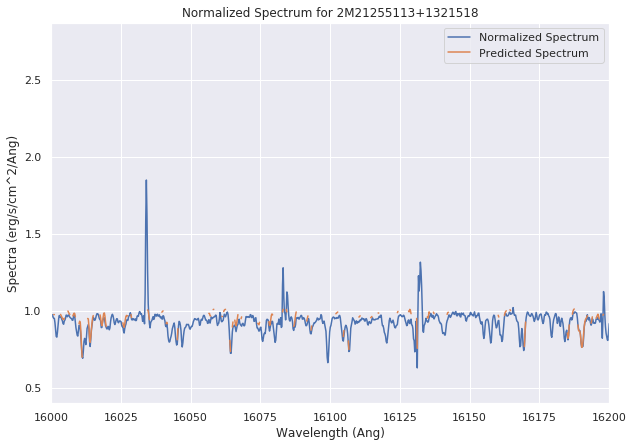

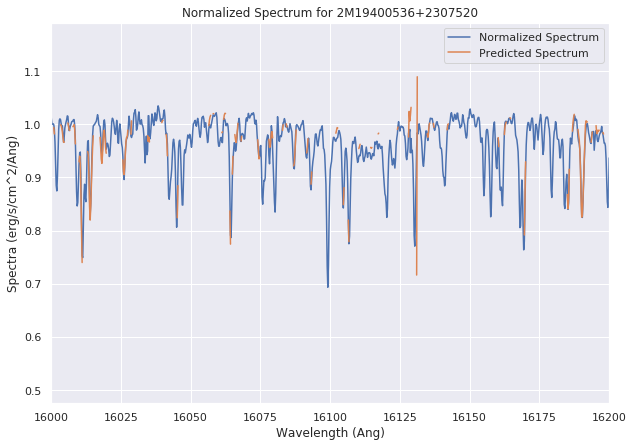

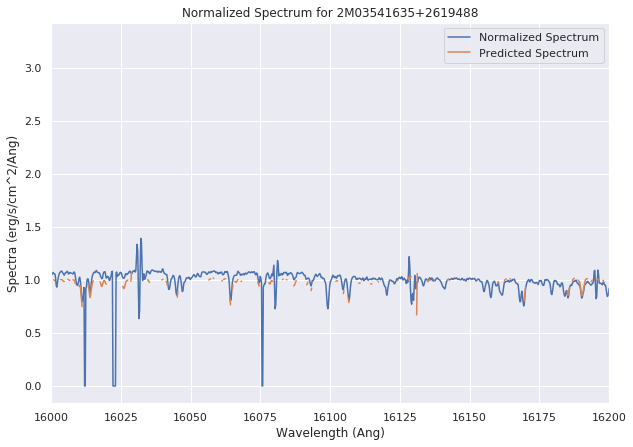

In [28]:
## predicting spectrum for 3 random stars in training set ##
# star '2M03533659+2512012' not in my training set

spectra_list = []
for star in stars:
    spectra, index = predict_spectrum(star)
    normalized_spectra = y_train[index]
    # graphng normalized spectrum
    plt.figure(figsize=(10,7))
    plt.plot(wavelength, normalized_spectra, label = 'Normalized Spectrum')
    plt.plot(wavelength, spectra, label = 'Predicted Spectrum')
    plt.title(f'Normalized Spectrum for {star}')
    plt.xlabel('Wavelength (Ang)')
    plt.ylabel('Spectra (erg/s/cm^2/Ang)')
    plt.xlim([16000,16200])
    plt.legend()
    plt.show()

# Problem 8
For each of the five labels i
, plot the gradient spectrum dfλ/di
. This will let you identify which
wavelengths are most sensitive to a particular label. For the gradient spectra of Si and Mg, mark the
3
locations of strong known Si and Mg lines. Do the regions of the spectrum where the gradient is large
correspond to known absorption lines?
Some well-known lines at APOGEE wavelengths can be found here.
Additionally, plot s
2
λ
. Do wavelengths with larger-than-average intrinsic scatter correspond to known
absorption lines?

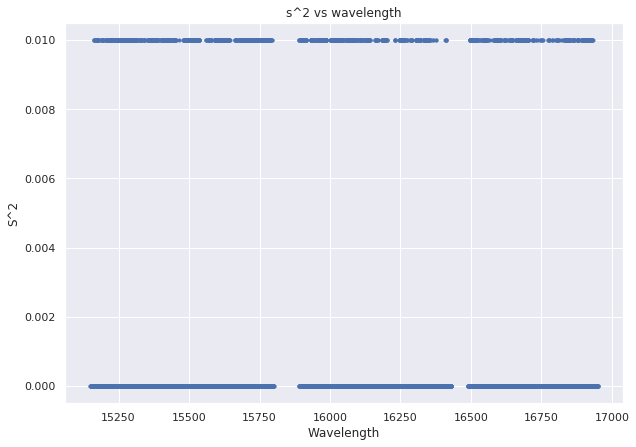

In [29]:
## plot s^2 ##

plt.figure(figsize=(10,7))
plt.plot(wavelength, s_values**2, '.')
plt.xlabel('Wavelength')
plt.ylabel('S^2')
plt.title('s^2 vs wavelength')
plt.show()

In [30]:
print("I'm pretty sure I calculated s wrong because my s values were either 0.1 or 0")

I'm pretty sure I calculated s wrong because my s values were either 0.1 or 0


# Problem 9
To test how well the model works, we’ll now use it to fit for the labels of spectra in the cross-validation
set. For each spectrum in the cross-validation set, use a nonlinear optimizer (Python has many options, we have found the “trf” or Trust Region Reflective method in scipy.optimize.curve_fit to be very
robust) to find the point in label-space at which the spectrum predicted by the model best matches
the observed spectrum (in a χ
2
sense, accounting for the uncertainty in the spectrum).
Now compare, for each of the five labels, the best-fit value obtained by the above procedure to the
ASPCAP-derived value in the allStar catalog for the validation set. That is, make plots of your best-fit
labels vs the ASPCAP labels with a one-to-one line for reference, and show the residuals. Measure
the bias and scatter for each label over the full cross-validation set. For a good model, these should be
small; for example, a scatter of about 30 K in Teff and 0.02 dex in [Fe/H] should be achievable. If you
aren’t happy with your model’s performance, go back to step 6.

In [31]:
## removing nan values in theta matrix ##

theta_matrix = np.nan_to_num(theta_matrix)

In [32]:
## defining function to predict labels ##

from scipy.optimize import curve_fit
def func(theta_matrix, a, b, c, d, e):
    varia = np.array([1, a, b, c, d, e, np.square(a), a*b, a*c, a*d, a*e, np.square(b), b*c, b*d, b*e, np.square(c),
                 c*d, c*e, np.square(d), d*e, np.square(e)])
    return varia.dot(theta_matrix)


In [33]:
## predicting labels ##

fit_labels = np.array([curve_fit(func,
                                 theta_matrix,
                                 y_test[index],
                                 sigma=X_test['Error'][index])[0] for index in range(len(y_test))])

In [34]:
## predicted labels ##

teffs = fit_labels[:,0]
loggs = fit_labels[:,1]
mhs = fit_labels[:,2]
mgfes = fit_labels[:,3]
sifes = fit_labels[:,4]

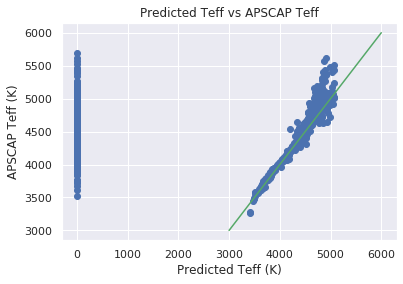

mean difference: 1510.041859833273


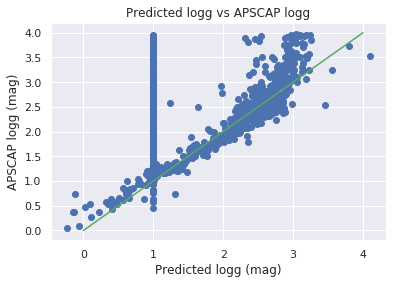

mean difference: 0.49840814107276354


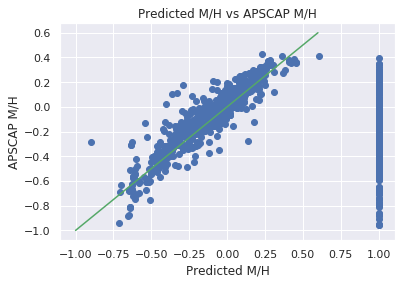

mean difference: -0.3604830543350631


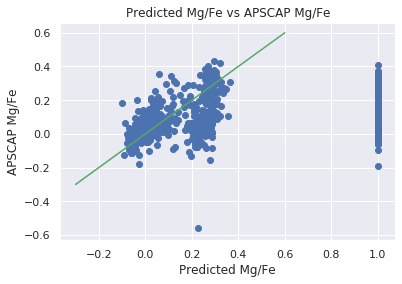

mean difference: -0.2948910038350915


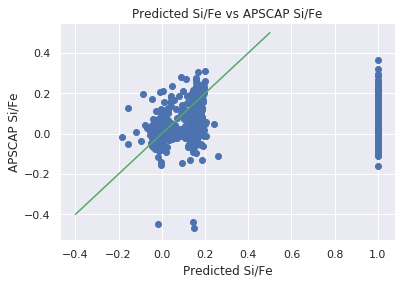

mean difference: -0.3106454200288607


In [35]:
## plotting the predicted labels vs APSCAP labels ##

teff_actual = [item[0] for item in X_test['Labels']]
plt.figure()
plt.scatter(teffs,teff_actual)
x = np.linspace(3000,6000)
plt.plot(x,x+0,'-g')
plt.title("Predicted Teff vs APSCAP Teff")
plt.xlabel("Predicted Teff (K)")
plt.ylabel("APSCAP Teff (K)")
plt.show()
print("mean difference:", np.mean(teff_actual - teffs))

logg_actual = [item[1] for item in X_test['Labels']]
plt.figure()
plt.scatter(loggs,logg_actual)
x = np.linspace(0,4)
plt.plot(x,x+0,'-g')
plt.title("Predicted logg vs APSCAP logg")
plt.xlabel("Predicted logg (mag)")
plt.ylabel("APSCAP logg (mag)")
plt.show()
print("mean difference:", np.mean(logg_actual-loggs))

mhs_actual = [item[2] for item in X_test['Labels']]
plt.figure()
plt.scatter(mhs,mhs_actual)
x = np.linspace(-1,.6)
plt.plot(x,x+0,'-g')
plt.title("Predicted M/H vs APSCAP M/H")
plt.xlabel("Predicted M/H")
plt.ylabel("APSCAP M/H")
plt.show()
print("mean difference:", np.mean(mhs_actual-mhs))

mgfes_actual = [item[3] for item in X_test['Labels']]
plt.figure()
plt.scatter(mgfes,mgfes_actual)
x = np.linspace(-.3,.6)
plt.plot(x,x+0,'-g')
plt.title("Predicted Mg/Fe vs APSCAP Mg/Fe")
plt.xlabel("Predicted Mg/Fe")
plt.ylabel("APSCAP Mg/Fe")
plt.show()
print("mean difference:", np.mean(mgfes_actual-mgfes))

sifes_actual = [item[4] for item in X_test['Labels']]
plt.figure()
plt.scatter(sifes,sifes_actual)
x = np.linspace(-.4,.5)
plt.plot(x,x+0,'-g')
plt.title("Predicted Si/Fe vs APSCAP Si/Fe")
plt.xlabel("Predicted Si/Fe")
plt.ylabel("APSCAP Si/Fe")
plt.show()
print("mean difference:", np.mean(sifes_actual-sifes))

# Problem 10 
Although your model should perform well in cross-validation in most cases, there are likely a few
objects for which the best-fit labels differ substantially from those in the allStar catalog. Investigate
these objects, and try to find out what has gone wrong. Did the optimizer get stuck in a local minimum?
Is there something wrong with the spectrum or continuum normalization? Are there flags in the catalog
indicating the allStar labels might not be reliable? Can you improve your model based on these tests?

I noticed that there are some spectra that consisted of only inf values and when I normalized the spectrum and error values, there were some inf or nan values. And because of the normalization process, I also had nan or inf values in my theta matrix. In trying to account for these values by either getting rid of them if the entire spectra were inf or nan, or by converting these values to numbers using np.nan_to_num, I ended up with a lot of 0 and 1 values. Maybe by getting rid of the stars with entirely nan or inf values to begin with before I started normalizing, or finding better ways to account for the gaps.

# Problem 11
For the ∼900 stars in your cross-validation set, plot a Kiel diagram (i.e. logg vs Teff). Color points
by their Fe/H. You should use labels you obtained through fitting, not the ASPCAP labels. Identify
known features. Comment on the presence (or absence) of trends with Fe/H. The paper by Holtzman
et al. (2015) should give you a sense of what this is expected to look like.
Download and overplot a 6 Gyr-old MIST isochrone of solar metallicity. How good (or poor) is the
agreement? Also plot an isochrone with [Fe/H] = -1. Does the [Fe/H]-trend in the isochrones agree
with that found in your fitting?

Reading in: MIST_iso_5ea718a1f3afb.iso.cmd
Reading in: MIST_iso_5ea719168efa3.iso.cmd


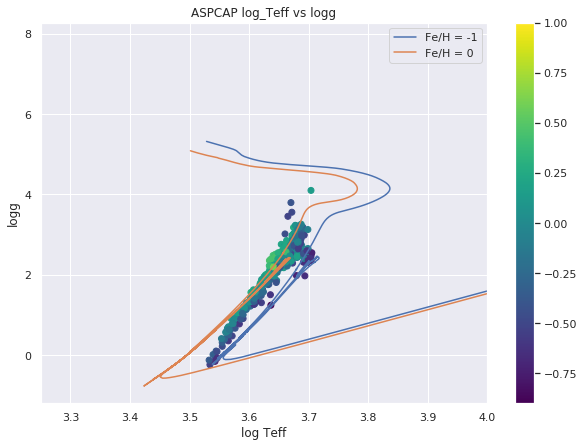

In [37]:
## overplotting 6 Gyr-old MIST isochrone of solar metallicity with Kiel diagram from test set ##

import read_mist_models

plt.figure(figsize=(10,7))
plt.scatter(np.log10(teffs), loggs, c=mhs, cmap='viridis')
plt.colorbar()
iso = read_mist_models.ISOCMD('MIST_iso_5ea718a1f3afb.iso.cmd')
plt.plot(iso.isocmds[0]['log_Teff'], iso.isocmds[0]['log_g'], label = "Fe/H = -1") 
iso2 = read_mist_models.ISOCMD('MIST_iso_5ea719168efa3.iso.cmd')
plt.plot(iso2.isocmds[0]['log_Teff'], iso2.isocmds[0]['log_g'], label = "Fe/H = 0") 
plt.title("ASPCAP log_Teff vs logg")
plt.ylabel("logg")
plt.xlabel("log Teff")
plt.xlim([3.25,4])
plt.legend()

plt.show()

Most of the more positive values are to the left next to the Fe/H = 0 isochrone, and the values approaching -1 are on the right. We can see that the form is similar to that of the red giant branch in HR diagrams. The agreement with the isochrones is fairly accurate. However, the fitted data has much less structure with where the Fe/H is placed and it seems to be much more scattered.

# Problem 12
Wrap your spectral model in MCMC using pymc3. Then, use it to fit the provided mystery spectrum. As always, state your priors. Plot a corner plot of your constraints on the five labels.
Depending on how you have implemented your spectral model, it may or may not be easy to make
it play nice with pymc3. If it’s not easy, a good workaround is to write the log-likelihood function
yourself and enroll it manually. See this tutorial for a worked example of how this can be done.
Comment on the formal parameter uncertainties on your fit. Do they seem reasonable, too small,
or too large? How do they compare to the typical errors of the ASPCAP-derived labels? How do they
compare to the typical errors you inferred from the scatter in cross-validation? If the magnitude of the
uncertainties is different from what you might expect, comment on factors that might explain this.

In [44]:
## normalizing the mystery spectrum ##

# getting wavelengths that correspond with 'is_continuum'==True
continuum = wavelength_file['wavelength'][wavelength_file['is_continuum']==True]

# rounding wavenlengths to 2 decimal points and split into sections
full_continuum = []
continuum1 = []
continuum2 = []
continuum3 = []
for wavelength in continuum:
    wavelength = round(wavelength, 2)
    full_continuum.append(wavelength)
    # (i) 15150 - 15800 ˚A
    if 15150 < wavelength < 15800:
        continuum1.append(wavelength)
    # (ii) 15890 - 16430 ˚A    
    elif 15890 < wavelength < 16430:
        continuum2.append(wavelength)
    # (iii) 16490 - 16950 ˚A
    elif 16490 < wavelength < 16950:
        continuum3.append(wavelength)

file = get_pkg_data_filename("mystery_spec_wiped.fits")

with fits.open(file) as hdul:
    
    spec = hdul[1].data
    error = hdul[2].data
    start = hdul[0].header['CRVAL1']
    step = hdul[0].header['CDELT1']
    num = hdul[0].header['NWAVE']

    end = start + step*num
    wvl = np.array(np.arange(start,end,step)) # log(wavelength)
    wvl = 10**wvl

    # round wavelengths to 2 decimal points and breaking up into sections
    full_wavelength = []
    wavelength1 = []
    wavelength2 = []
    wavelength3 = []
    for w in wvl:
        w = round(w, 2)
        full_wavelength.append(w)
        # (i) 15150 - 15800 ˚A
        if 15150 < w < 15800:
            wavelength1.append(w)
        # (ii) 15890 - 16430 ˚A    
        elif 15890 < w < 16430:
            wavelength2.append(w)
        # (iii) 16490 - 16950 ˚A
        elif 16490 < w < 16950:
            wavelength3.append(w)


    # create dataframe of wavelength and spectra
    full_df = pd.DataFrame({'wavelength': np.array(full_wavelength).byteswap().newbyteorder(),
                              'spectra': spec.byteswap().newbyteorder()}).set_index('wavelength')

    # getting the spectra from wavelengths that correspond to npz file and are in continuum
    df_1 = full_df[full_df.index.isin(continuum1)]
    df_2 = full_df[full_df.index.isin(continuum2)]
    df_3 = full_df[full_df.index.isin(continuum3)]

    # fitting least squares fit of Chebyshev series to data in sections
    cheb1 = np.polynomial.chebyshev.chebfit(continuum1, df_1['spectra'], 5)
    cheb2 = np.polynomial.chebyshev.chebfit(continuum2, df_2['spectra'], 5)
    cheb3 = np.polynomial.chebyshev.chebfit(continuum3, df_3['spectra'], 5)

    # evaluating the entire spectrum using coefficients found in fitting
    val1 = np.polynomial.chebyshev.chebval(wavelength1, cheb1)
    val2 = np.polynomial.chebyshev.chebval(wavelength2, cheb2)
    val3 = np.polynomial.chebyshev.chebval(wavelength3, cheb3)

    # putting into dataframe
    pseudo_df = pd.DataFrame({'wavelength': [*wavelength1,*wavelength2,*wavelength3],
                              'spectra': [*val1,*val2,*val3]})
    new_df = full_df.join(pseudo_df.set_index('wavelength'),lsuffix = 'A').drop('spectraA', axis = 1)

    # normalizing spectra and error arrays
    normalized_spectra = spec/new_df['spectra']
    normalized_spectra = np.array(normalized_spectra)
    normalized_error = error/np.std(new_df['spectra'])
    wavelength = new_df.index[new_df['spectra'].notna()]
    normalized_spectra = [x for x in normalized_spectra if (str(x)!='nan' and str(x)!='inf')]
    normalized_error = [x for x in normalized_error if (str(x)!='nan' and str(x)!='inf')]


In [46]:
## setting up MCMC ##

import pymc3 as pm
import theano.tensor as tt

model = pm.Model()
with model:

    teff = pm.Normal('teff',mu=0,sigma=5)
    logg = pm.Normal('logg',mu=0,sigma=5)
    mh  = pm.Normal('mh',mu=0,sigma=5)
    mgfe = pm.Normal('mgfe',mu=0,sigma=5)
    sife = pm.Normal('sife',mu=0,sigma=5)
    labels = [1, teff, logg, mh, mgfe, sife, teff*teff, teff*logg, teff*mh, teff*mgfe, teff*sife, logg*logg, 
             logg*mh, logg*mgfe, logg*sife, mh*mh, mh*mgfe, mh*sife, mgfe*mgfe, mgfe*sife, sife*sife]

    # model
    mu = pm.math.dot(labels,theta_matrix)
    
    # likelihood
    flux = pm.Normal('flux',mu=mu,observed=normalized_spectra)

In [47]:
## MCMC ##

import exoplanet as xo
with model:
    trace = pm.sample(tune=500,
                      draws=500,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sife, mgfe, mh, logg, teff]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 243.88draws/s]


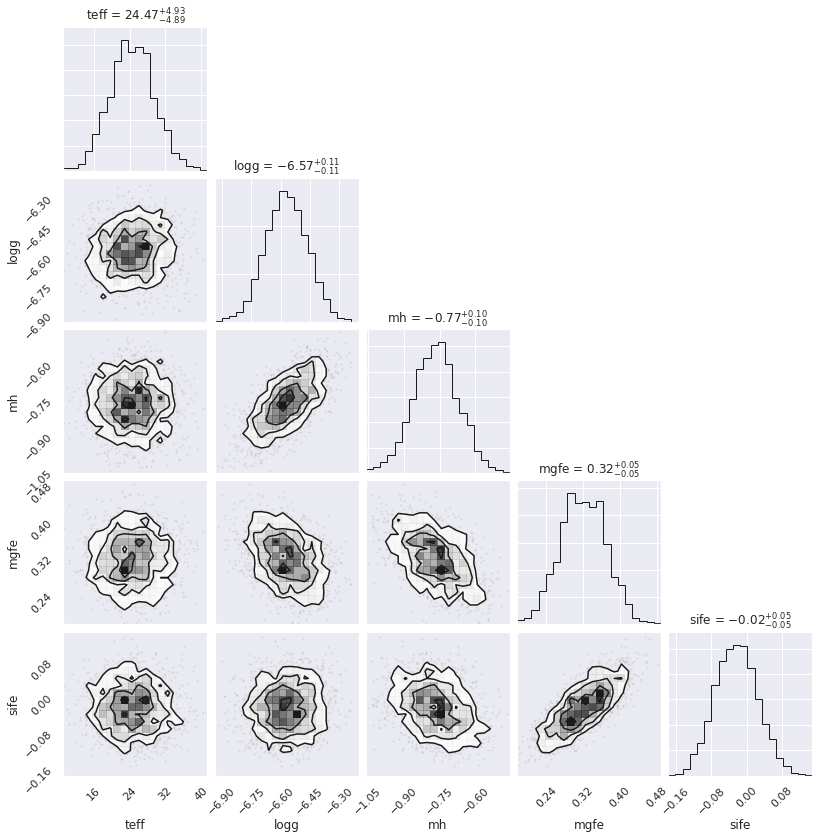

In [48]:
## corner plot ##

samples = pm.trace_to_dataframe(trace)
corner.corner(samples,show_titles=True);

My parameter uncertainties look reasonable, except my Teff value but this may be due to the fact that I did not rescale my labels to order of unity.

# Problem 13 
Use your model to make a movie showing how the spectrum changes with metallicity at fixed Teff and
logg. For clarity, show only the region of the spectrum from 16000 to 16200 Angstrom. Vary [Fe/H]
from -1 to 0.5 and fix the atmospheric parameters to reasonable values. The matplotlib “animate” tool is useful for making movies. Unfortunately, it is not currently possible to save movies using ffmpeg on Datahub. If you are working on your own computer, this should
not be a problem. If you are using Datahub, a reasonable option is to save frames of the movie and
then stitch them together.

In [52]:
## getting wavelengths that are from 16000 to 16200 Angstrom ##

get_wavelength_index = full_df.reset_index()
get_wavelength_index = get_wavelength_index[get_wavelength_index['wavelength'] < 16200]
get_wavelength_index = get_wavelength_index[get_wavelength_index['wavelength']> 16000]
get_wavelength_index ## indices [4187:5085]

,wavelength,spectra
4187,16000.07,3423.997559
4188,16000.30,3387.848145
4189,16000.52,3369.979004
4190,16000.74,3382.562500
4191,16000.96,3411.361572
4192,16001.18,3419.225098
4193,16001.40,3385.812012
4194,16001.62,3289.958740
4195,16001.84,3171.401123
4196,16002.06,3126.017822


In [53]:
## getting predicted spectra given specific label values ##

mh_list = np.linspace(-1,0.5,10) 
teff = 0.36
logg = -6.50
mgfe = 0.14
sife = -0.17
new_theta = theta_matrix[:,4187:5086]

ydata = []
for mh in mh_list:
    label = np.array([1, teff, logg, mh, mgfe, sife, teff*teff, teff*logg, teff*mh, teff*mgfe, teff*sife,
         logg*logg, logg*mh, logg*mgfe, logg*sife, mh*mh, mh*mgfe, mh*sife, mgfe*mgfe, mgfe*sife, sife*sife])
    ydata.append(np.dot(label,new_theta))
x = np.array(get_wavelength_index['wavelength'])

In [38]:
"""
## making and saving plot for all 10 frames ##

fig = plt.figure()
plt.ylabel('Flux (erg/s/cm^2/Ang)')
plt.xlabel('Wavelength A')
plt.title("Spectra from 16000 to 16200 A, varying Fe/H")
plt.plot(x, ydata[9])
plt.show()
fig.savefig('gif/frame10', dpi=fig.dpi)
"""

'\n## making and saving plot for all 10 frames ##\n\nfig = plt.figure()\nplt.ylabel(\'Flux (erg/s/cm^2/Ang)\')\nplt.xlabel(\'Wavelength A\')\nplt.title("Spectra from 16000 to 16200 A, varying Fe/H")\nplt.plot(x, ydata[9])\nplt.show()\nfig.savefig(\'gif/frame10\', dpi=fig.dpi)\n'

In [72]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 245kB/s eta 0:00:01
You are using pip version 9.0.3, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [74]:
"""
## creating gif ##

import imageio
images = []
filenames = ['frame1.png', 'frame2.png', 'frame3.png', 'frame4.png', 'frame5.png', 
             'frame6.png', 'frame7.png', 'frame8.png', 'frame9.png', 'frame10.png']
path = 'gif/'
for filename in filenames:
    images.append(imageio.imread(path+filename))
imageio.mimsave('gif/p13.gif', images)
"""

# Problem 14 
Make a movie showing how the same region of the spectrum changes as a star ascends the red giant
branch. Fix [Fe/H]=0, and vary logg from 3.5 to 0.5, simultaneously varying Teff such that the star
moves along an isochrone.
Comment on the similarities and differences of how the spectrum changes when the composition changes
vs. when the star moves up the RGB at fixed composition. How can one tell the difference between a
cool, low-logg star and a warmer, higher-logg star that is more metal-rich?

In [54]:
## loading isochrone of [Fe/H] = 0 and getting values where 0.5 < logg < 3.5 ##

iso2 = read_mist_models.ISOCMD('MIST_iso_5ea719168efa3.iso.cmd')
iso_teff= 10**(iso2.isocmds[0]['log_Teff'])
iso_logg = iso2.isocmds[0]['log_g']
df = pd.DataFrame({'Teff': iso_teff,
                     'logg': iso_logg})
iso_teff = np.array(df['Teff'][(df['logg'] < 3.5) & (df['logg'] > 0.5)])
iso_logg = np.array(df['logg'][(df['logg'] < 3.5) & (df['logg'] > 0.5)])

Reading in: MIST_iso_5ea719168efa3.iso.cmd


In [55]:
## predicting spectra with specific label values ##

mh = 0
mgfe = 0.14
sife = -0.17

ydata = []
for teff, logg in zip(iso_teff,iso_logg):
    label = np.array([1, teff, logg, mh, mgfe, sife, teff*teff, teff*logg, teff*mh, teff*mgfe, teff*sife,
         logg*logg, logg*mh, logg*mgfe, logg*sife, mh*mh, mh*mgfe, mh*sife, mgfe*mgfe, mgfe*sife, sife*sife])
    ydata.append(np.dot(label,new_theta))
x = np.array(get_wavelength_index['wavelength'])


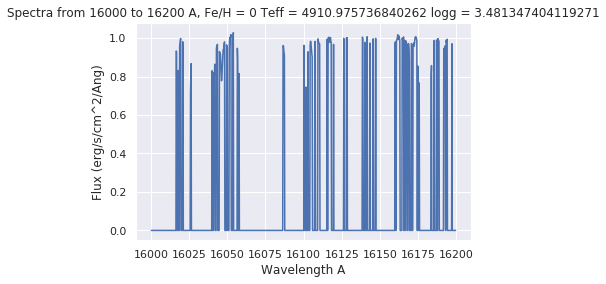

In [133]:
"""
## making and saving plot for only 9 frames ##

fig = plt.figure()
plt.ylabel('Flux (erg/s/cm^2/Ang)')
plt.xlabel('Wavelength A')
plt.title(f"Spectra from 16000 to 16200 A, Fe/H = 0 Teff = {iso_teff[0]} logg = {iso_logg[0]}")
plt.plot(x, ydata[0])
plt.show()
fig.savefig('gif/14frame1', dpi=fig.dpi)
"""

In [134]:
"""
## creating gif ##

import imageio
images = []
filenames = ['14frame1.png', '14frame2.png', '14frame3.png', '14frame4.png', '14frame5.png', 
             '14frame6.png', '14frame7.png', '14frame8.png', '14frame9.png']
path = 'gif/'
for filename in filenames:
    images.append(imageio.imread(path+filename))
imageio.mimsave('gif/p14.gif', images)
"""

It looks as though when composition changes, the spectrum increases in flux whereas when the star moves up the RGB at fixed composition, the spectrum decreases in flux. This may also be due to errors in my label calculation due to errors in my normalization and theta matrix.

# Problem 15 
One complication not accounted for in your spectral model is the fact that many stars are in binary
systems. If the angular separation between the two components of a binary is small, they will fall
within the same spectroscopic fiber, and the observed spectrum will really be the sum of the spectra of
two different stars. Discuss how this might affect your results. If it would lead to bias in the inferred
labels, in which direction would you expect the bias to go? How might you correct for it?

If the observed spectra is the sum of two different stars, then this would affect the flux values which may lead us to make assumptions that a star is hotter than it is and cause issues in calculating metal abundances. This would lead bias to increase as it would try to generalize the model to fit these cases and be unable to accurately fit spectra of a single star. To correct for it, we can maybe include bound for temperature to ensure that the observed spectra is not a sum of two different stars or include more labels such as rotation velocity to help detect binary systems.

# Probelm 16
Finally, let’s try a completely different way of measuring labels from spectra. So far, we’ve made a
made a model to predict the spectrum as a function of labels, and then used that model to fit spectra
in a traditional χ
2
sense. What if we could instead predict labels as a function of spectra? To do this,
we’ll use deep learning.
Train a neural network that takes in a normalized spectrum and predicts the same label vector that
characterized your spectral model. You may find it useful to regularize the labels so they are of order
unity. Experiment with different neural network architectures and hyper-parameters, carrying out onthe-fly validation to tune the network. Any neural network implementation is fine; we have have found
PyTorch, Theano, TensorFlow, and Keras to work well. Once you find an architecture you are happy
with, plot the training and validation loss as a function of training step.

In [56]:
teff = [item[0] for item in data['Labels']]
logg = [item[1] for item in data['Labels']]
m = [item[2] for item in data['Labels']]
mg = [item[3] for item in data['Labels']]
si = [item[4] for item in data['Labels']]
data['Teff'] = teff
data['logg'] = logg
data['M/H'] = m
data['Mg/Fe'] = mg
data['Si/Fe'] = si

In [57]:
## designated train and test groups ##

X_train_net, X_test_net, y_train_net, y_test_net = train_test_split(
     data['Spectra'], data[['Teff', 'logg', 'M/H', 'Mg/Fe', 'Si/Fe']], test_size=0.2, random_state=42)
y_train_net = np.array(y_train_net)
y_test_net = np.array(y_test_net)
X_train_net = np.array([np.array(lst) for lst in X_train_net])
X_test_net = np.array([np.array(lst) for lst in X_test_net])

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_net)  
X_train_net = scaler.transform(X_train_net)  

# apply same transformation to test data
X_test_net = scaler.transform(X_test_net)

In [60]:
model = Sequential()
# num_input_features = X_train_net.shape[1]
model.add(Dense(7451, input_dim = 7451, 
                  activation="linear", kernel_initializer='normal'))
model.add(Dense(128,  input_dim = 128,activation="linear", kernel_initializer='normal'))
model.add(Dense(5,  activation="linear", kernel_initializer='normal'))
# model.add(Dense(1, activation="linear", kernel_initializer='random_uniform'))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7451)              55524852  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               953856    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 56,479,353
Trainable params: 56,479,353
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])

In [63]:
model.fit(X_train_net, y_train_net, batch_size=170, epochs=500, verbose=1)

Train on 1482 samples
Epoch 1/500
1482/1482 [==============================] - 5s 4ms/sample - loss: 4311576.8590 - mae: 934.0239 - mse: 4311576.5000
Epoch 2/500
1482/1482 [==============================] - 4s 3ms/sample - loss: 4268130.8212 - mae: 931.0128 - mse: 4268131.0000
Epoch 3/500
1482/1482 [==============================] - 3s 2ms/sample - loss: 4264898.9318 - mae: 930.6866 - mse: 4264899.0000
Epoch 4/500
1482/1482 [==============================] - 3s 2ms/sample - loss: 4252362.4831 - mae: 930.6285 - mse: 4252362.5000
Epoch 5/500
1482/1482 [==============================] - 3s 2ms/sample - loss: 4256411.0783 - mae: 930.9249 - mse: 4256411.0000
Epoch 6/500
1482/1482 [==============================] - 3s 2ms/sample - loss: 4259316.9035 - mae: 929.3973 - mse: 4259317.0000
Epoch 7/500
1482/1482 [==============================] - 3s 2ms/sample - loss: 4248472.9501 - mae: 927.2946 - mse: 4248472.5000
Epoch 8/500
1482/1482 [==============================] - 3s 2ms/sample - loss: 425

In [64]:
pred = model.predict(X_test_net)

mean difference: -36.788006312120956


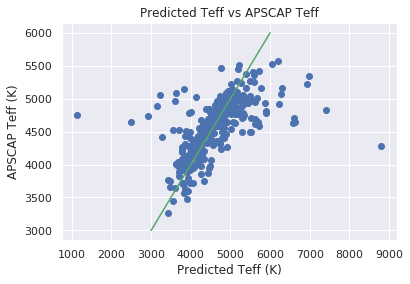

In [65]:
plt.scatter(pred[:,0], y_test_net[:,0])
x = np.linspace(3000,6000)
plt.plot(x,x+0,'-g')
# plt.xlim(-1,1)
plt.title("Predicted Teff vs APSCAP Teff")
plt.xlabel("Predicted Teff (K)")
plt.ylabel("APSCAP Teff (K)")

print("mean difference:", np.mean(y_test_net[:,0] - pred[:,0]))


mean difference: -2.5709358237864515


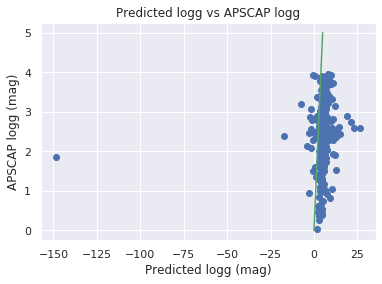

In [66]:
plt.scatter(pred[:,1], y_test_net[:,1])
x = np.linspace(0,5)
plt.plot(x,x+0,'-g')
plt.title("Predicted logg vs APSCAP logg")
plt.xlabel("Predicted logg (mag)")
plt.ylabel("APSCAP logg (mag)")

print("mean difference:", np.mean(y_test_net[:,1] - pred[:,1]))

mean difference: -0.47543632966589255


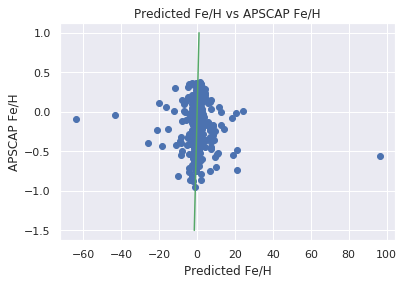

In [67]:
plt.scatter(pred[:,2], y_test_net[:,2])
x = np.linspace(-1.5,1)
plt.plot(x,x+0,'-g')
plt.title("Predicted Fe/H vs APSCAP Fe/H")
plt.xlabel("Predicted Fe/H")
plt.ylabel("APSCAP Fe/H")

print("mean difference:", np.mean(y_test_net[:,2] - pred[:,2]))

mean difference: -0.19627656378830982


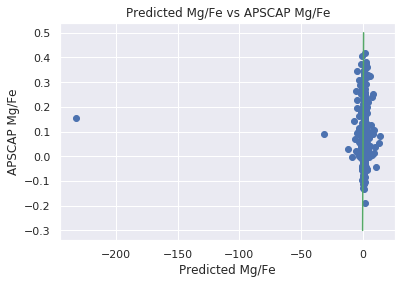

In [68]:
plt.scatter(pred[:,3], y_test_net[:,3])
x = np.linspace(-0.3,0.5)
plt.plot(x,x+0,'-g')
plt.title("Predicted Mg/Fe vs APSCAP Mg/Fe")
plt.xlabel("Predicted Mg/Fe")
plt.ylabel("APSCAP Mg/Fe")

print("mean difference:", np.mean(y_test_net[:,3] - pred[:,3]))

mean difference: 2.4656008025179452


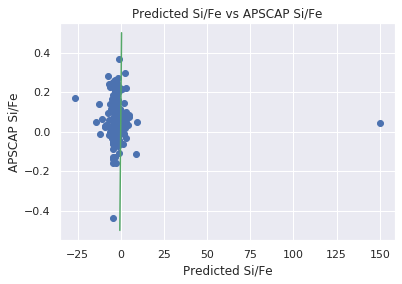

In [69]:
plt.scatter(pred[:,4], y_test_net[:,4])
x = np.linspace(-0.5,0.5)
plt.plot(x,x+0,'-g')
plt.title("Predicted Si/Fe vs APSCAP Si/Fe")
plt.xlabel("Predicted Si/Fe")
plt.ylabel("APSCAP Si/Fe")

print("mean difference:", np.mean(y_test_net[:,4] - pred[:,4]))

The neural net performed better than my model, with my mean differences in my neural net being much smaller than the mean differences in my model. This is almost most definitely related to how I normalized my data and therefore acquired my theta matrix, because I had a lot of nan and inf values that I then changed to numerical values using np.nan_to_num. Nerual nets can acheive much better results than simple linear models as they are nonparametric and able to approximate any function, not just linear ones. These models are tuned/trained specifically to the data, rather than linear models which have a specific function that needs be to optimized to fit the function. The draw back is that it can take much longer to preprocess, develop, train, and tune hyperparameters at the cost of getting better results. On the other hand, a linear model is great for data that we know may be linear with the labels, as it is extremely fast and can get good results depending on the data.